<a href="https://colab.research.google.com/github/cwerries/IANNWTF_Group_14_Submissions/blob/master/Image_colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
import os
from google.colab import drive
drive._mount('/content/drive')
#os.chdir('drive/MyDrive/test_images_random.zip')
#import glob


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!unzip /content/drive/MyDrive/test_images_random.zip -q

In [3]:
import os
# import glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
import time
import urllib
from IPython import display

import cv2
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPool2D, Conv2DTranspose, Reshape, Activation, BatchNormalization, GlobalAvgPool2D, LeakyReLU, Concatenate
from tensorflow.keras.activations import relu

# Import data

In [4]:
#dataset from drive, download: https://drive.google.com/drive/folders/18ODl_6aMBWLxiOoq2U2mTuG_gKtQuxPl
with tf.device('/device:gpu:0'):
  path = '/content/drive/MyDrive/colorful_imgs'
  data_rgb = []
  data_g = []
  IMG_SIZE = 128

  for img in os.listdir(path):
      images = cv2.imread(os.path.join(path, img))#, cv2.IMREAD_GRAYSCALE
      # CV has BGR so to correctly plot we need to invert images
      rgb_images = np.flip(images, axis=-1) 
      # resize images
      rgb_images = cv2.resize(rgb_images, (IMG_SIZE, IMG_SIZE))
      # convert to grayscale images
      #gray_images = rgb_images.convert('L').reshape()
      # create two data arrays
      #data_g.append(gray_images)
      data_rgb.append(rgb_images)
      #plt.imshow(images)#, cmap = "gray"
      #plt.show()
      #break

  print("Number of images: ", len(data_rgb))
  print("Size images: ", len(data_rgb[0]))

Number of images:  2882
Size images:  128


#Utility Functions

### Input pipeline

In [5]:
# Description:Input pipeline to prepare dataset
#             Inputs: images
#             Outputs: prepared images
def prepare(data, batch_size):
    # add grayscale image to tensor -> (grayscale image, rgb image)
    data = data.map(lambda rgb_img, empty: (tf.image.rgb_to_grayscale(rgb_img), rgb_img))
    
    # convert datatype to float32
    data = data.map(lambda gray_img, rgb_img: (tf.cast(gray_img, tf.float32), tf.cast(rgb_img, tf.float32)))
    
    # normalize image pixels to range [-1, 1]
    data = data.map(lambda gray_img, rgb_img: ((gray_img/127.5-1.), (rgb_img/127.5-1.)))
    
    #shuffle, batch, prefetch
    data = data.shuffle(500).batch(batch_size).prefetch(batch_size)
    
    #return preprocessed dataset
    return data

###Visualization

In [6]:
# Utility function to plot images
def plot_imgs(img, n, title, color):
    
    # display images
    plt.figure(figsize=(20, 10))
    
    for i in range(n): 
        img_int = tf.cast((img[i]+1.0)*127.5, tf.int32)

        ax = plt.subplot(2, n, i + 1)
        plt.title(title)
        if color:
            plt.imshow(img_int)
        else:
            plt.imshow(tf.squeeze(img_int), cmap="gray")
            
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()

# Prepare data

### Split data

In [7]:
# SHuffle data
np.random.shuffle(data_rgb)

# Splitting data
ratio_train = 0.8
train_len = round(len(data_rgb)*ratio_train)

train_images = data_rgb[:train_len]
test_images = data_rgb[train_len:]

In [8]:
batch_size = 32
with tf.device('/device:gpu:0'):
  # Create tensorflow datasets for the training and test data.
  train_ds = tf.data.Dataset.from_tensor_slices((train_images, tf.constant(np.zeros(len(train_images)))))
  test_ds = tf.data.Dataset.from_tensor_slices((test_images, tf.constant(np.zeros(len(test_images)))))

  # x = 0
  # for i in train_ds:
  #     if x==0:
  #         print(i)
  #         x+=1
          
  # Prepare the images
  train_ds = prepare(train_ds, batch_size)
  test_ds = prepare(test_ds, batch_size)

###Show sample data

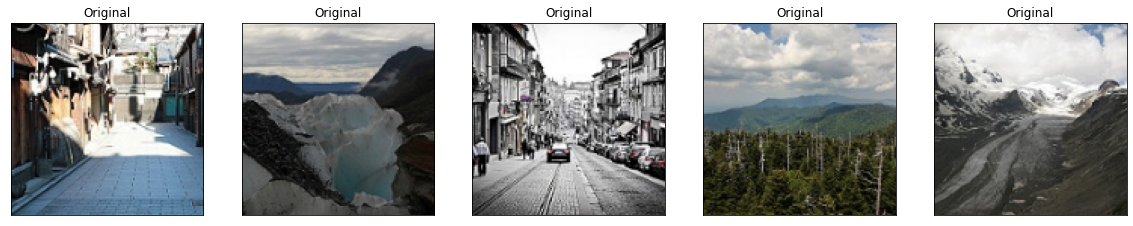

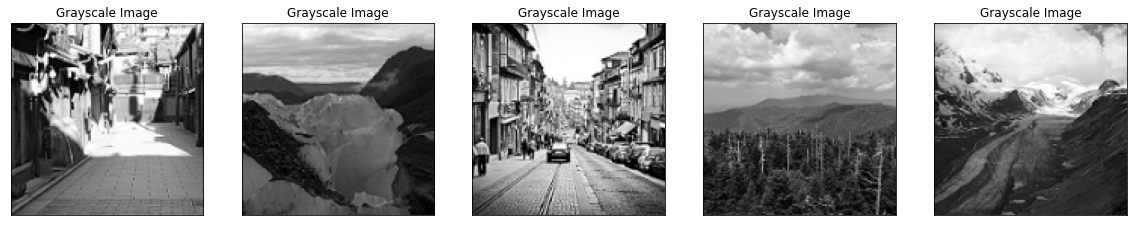

In [9]:
for g, rgb in train_ds:
    plot_imgs(rgb, 5, "Original", True)
    plot_imgs(g, 5, "Grayscale Image", False)
    break

# Generator

###Downsampling

In [10]:
class Downsampler(tf.keras.Model):

    def __init__(self, depth, drop):
        super(Downsampler, self).__init__()
        self.depth = depth
        self.drop = drop
        # , kernel_regularizer = tf.keras.regularizers.L2(0.001)
        
        #maxpool2d not for first layer
        self.maxpool = MaxPool2D((2, 2), strides=2)

        self.conv_1 = Conv2D(filters=depth/2, kernel_size=3, strides=1, padding='same')
        self.batchnorm_1 = BatchNormalization()
        self.act_1 = LeakyReLU(alpha=0.2)
        self.dropout_1 = Dropout(drop)
        
        self.conv_2 = Conv2D(filters=depth, kernel_size=3, strides=1, padding='same', kernel_regularizer = tf.keras.regularizers.L2(0.001))
        self.batchnorm_2 = BatchNormalization()
        self.act_2 = LeakyReLU(alpha=0.2)
        self.dropout_2 = Dropout(drop)
        
        self.conv_3 = Conv2D(filters=depth, kernel_size=3, strides=1, padding='same', kernel_regularizer = tf.keras.regularizers.L2(0.001))
        self.batchnorm_3 = BatchNormalization()
        self.act_3 = LeakyReLU(alpha=0.2)
        
        
    @tf.function
    def call(self, inputs, training, maxpool):
        
        if maxpool == True:
            inputs = self.maxpool(inputs)
            
        x = self.conv_1(inputs)
        x = self.batchnorm_1(x)
        x = self.act_1(x)
        
        if training == True:
            x = self.dropout_1(x)
        
        x = self.conv_2(x)
        x = self.batchnorm_2(x)
        x = self.act_2(x)
        
        if training == True:
            x = self.dropout_2(x)
            
        x = self.conv_3(x)
        x = self.batchnorm_3(x)
        x = self.act_3(x)
        
        return x

### Upsampling

In [11]:
class Upsampler(tf.keras.Model):

    def __init__(self, depth, drop):
        super(Upsampler, self).__init__()
        # Dropout after batch normalization???
        self.depth = depth
        self.drop = drop
        
        self.conv_1 = Conv2D(filters=depth, kernel_size=3, strides=1, padding='same')
        self.batchnorm_1 = BatchNormalization()
        self.act_1 = relu
        self.dropout_1 = Dropout(drop)
        
        self.conv_2 = Conv2D(filters=depth, kernel_size=3, strides=1, padding='same', kernel_regularizer = tf.keras.regularizers.L2(0.001))
        self.batchnorm_2 = BatchNormalization()
        self.act_2 = relu
        self.dropout_2 = Dropout(drop)
        
        # skip transpose for last layer
        self.tconv_1 = Conv2DTranspose(filters=depth, kernel_size=3, strides=2, padding='same', activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.001))

        
    @tf.function
    def call(self, inputs, training, transpose):
        
        x = self.conv_1(inputs)
        x = self.batchnorm_1(x)
        x = self.act_1(x)
        
        if training == True:
            x = self.dropout_1(x)
        
        x = self.conv_2(x)
        x = self.batchnorm_2(x)
        x = self.act_2(x)
        
        if training == True:
            x = self.dropout_2(x)
        
        # skip transpose for last layer
        if transpose == True:
            x = self.tconv_1(x)
        
        return x

###Merge

In [12]:
# U-Net
class Generator(tf.keras.Model):

    def __init__(self, depth, drop_down, drop_up):
        super(Generator, self).__init__()
        #Input = (128,128,1)
        self.depth = depth
        self.drop_down = drop_down
        self.drop_up = drop_up
        
        self.down_1 = Downsampler(depth, drop_down)#filt=32
        self.down_2 = Downsampler(depth*2, drop_down)#64
        self.down_3 = Downsampler(depth*4, drop_down)#128
        self.down_4 = Downsampler(depth*8, drop_down)#256
        
        # Convolutional transpostion only for last layer
        self.tconv_1 = Conv2DTranspose(filters=depth*4, kernel_size=3, strides=2, padding='same', activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.001))

        self.concat_1 = Concatenate()
        self.up_1 = Upsampler(depth*4, drop_up)
        self.concat_2 = Concatenate()
        self.up_2 = Upsampler(depth*2, drop_up)
        self.concat_3 = Concatenate()
        self.up_3 = Upsampler(depth, drop_up)

        self.color = Conv2D(3, kernel_size = 1, strides = 1, padding='same', activation='tanh')
 

    @tf.function
    def call(self, inputs, training): #128, 128, 1
        #downsampling
        x1 = self.down_1(inputs, training, False)  # 128,128,32
        x2 = self.down_2(x1, training, True)       # 64,64,64
        x3 = self.down_3(x2, training, True)       # 32,32,128
        x4 = self.down_4(x3, training, True)       # 16,16,256
        
        #upsampling -> 
        x5 = self.tconv_1(x4)                   # 32,32,128
        
        x6 = self.concat_1([x3, x5])            # 32,32,256
        x7 = self.up_1(x6, training, True)      # 64,64,64

        x8 = self.concat_2([x2, x7])            # 64,64,128
        x9 = self.up_2(x8, training, True)     # 128,128,32
        
        x10 = self.concat_3([x1, x9])            # 128,128,64
        x11 = self.up_3(x10, training, False)     # 128,128,32
        
        out = self.color(x11)                   # 128,128,3
        
        return out

# Discriminator

In [13]:
# https://www.tensorflow.org/tutorials/generative/pix2pix
class Discriminator(tf.keras.Model):

    def __init__(self, depth, drop):
        super(Discriminator, self).__init__()
        self.depth = depth
        self.drop = drop
        # 128x128x3
        self.conv_1 = Conv2D(filters = 1*depth, kernel_size = 7, strides = 2, padding = 'same', activation=LeakyReLU(alpha=0.2), input_shape=(128, 128, 3))
        self.dropout_1 = Dropout(drop) #61x61x32

        self.conv_2 = Conv2D(filters = 2*depth, kernel_size = 5, strides = 2, padding = 'same', activation=LeakyReLU(alpha=0.2))
        self.dropout_2 = Dropout(drop) #29x29x64
        
        self.conv_3 = Conv2D(filters = 2*depth, kernel_size = 5, strides = 1, padding = 'same', activation=LeakyReLU(alpha=0.2))
        self.dropout_3 = Dropout(drop) #25x25x64
        
        self.conv_4 = Conv2D(filters = 4*depth, kernel_size = 3, strides = 1, padding = 'same', activation=LeakyReLU(alpha=0.2), kernel_regularizer = tf.keras.regularizers.L2(0.001))
        self.dropout_4 = Dropout(drop) #23x23x128
        
        self.conv_5 = Conv2D(filters = 8*depth, kernel_size = 3, strides = 1, padding = 'same', activation=LeakyReLU(alpha=0.2), kernel_regularizer = tf.keras.regularizers.L2(0.001))
        self.dropout_5 = Dropout(drop) #21x21x256
        
        self.maxpool = MaxPool2D() #10x10x256
        self.glob_pool = GlobalAvgPool2D() #256
        
        #self.dense = Dense(256, activation="relu")
        self.dense_1 = Dense(128, activation="relu")
        self.dense_2 = Dense(16, activation="relu")
        self.dense_3 = Dense(1, activation="sigmoid")


    @tf.function
    def call(self, inputs, training):
        x = self.conv_1(inputs)
        if training == True:
            x = self.dropout_1(x)
            
        x = self.conv_2(x)
        if training == True:
            x = self.dropout_2(x)
            
        x = self.conv_3(x)
        if training == True:
            x = self.dropout_3(x)
            
        x = self.conv_4(x)
        if training == True:
            x = self.dropout_4(x)
            
        x = self.conv_5(x)
        if training == True:
            x = self.dropout_5(x)
        
        x = self.maxpool(x)
        x = self.glob_pool(x)
        
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return x

# Losses

###Discriminator Loss

In [14]:
# loss of  discriminator is based on how well the discriminator detected fake images as fake and real images as real
def get_discriminator_loss(bce_loss, real_prediction, fake_prediction):

    # compute BCE between  generators output on fake images and all labels=0
    fake_loss = bce_loss(fake_prediction, tf.zeros_like(fake_prediction))
    # compute BCE between generators output on the real images and all labels = 1
    real_loss = bce_loss(real_prediction, tf.ones_like(real_prediction))
    #Add them both to receive the resulting loss of the discriminator
    total_loss = real_loss + fake_loss
    
    return total_loss

###Generator Loss

In [15]:
# loss of generator is estimated by how well the generator was able to fool the discriminator
def get_generator_loss(bce_loss, fake_prediction):
    return bce_loss(fake_prediction, tf.ones_like(fake_prediction))
  # Mean absolute error
#   l1_loss = tf.reduce_mean(tf.abs(target - fake_prediction))
    #LAMBDA = e.g. 100
#   total_gen_loss = gan_loss + (LAMBDA * l1_loss)

#   return total_gen_loss, gan_loss, l1_loss

#Train step

In [16]:
def train_step(generator, discriminator, g_images, rgb_images, bce_loss, discriminator_optimizer, generator_optimizer, batch_size):
    # discriminator sees a batch of rgb images and a batch of the generated
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:

        # each training step generator is fed with random noise and creates images from it
        generated_images = generator(g_images, True)

        real_prediction = discriminator(rgb_images, True)
        fake_prediction = discriminator(generated_images, True)

        # calculate losses
        discriminator_loss = get_discriminator_loss(bce_loss, real_prediction, fake_prediction)
        generator_loss = get_generator_loss(bce_loss, fake_prediction)


    discriminator_gradients = d_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    generator_gradients = g_tape.gradient(generator_loss, generator.trainable_variables)

    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    
    return discriminator_loss, generator_loss

#Test step

In [17]:
def test(generator, discriminator, dataset, bce_loss, batch_size):
    d_loss_aggregator = []
    g_loss_aggregator = []
    
    for g_images, rgb_images in dataset:
        generated_images = generator(g_images, False)

        real_prediction = discriminator(rgb_images, False)
        fake_prediction = discriminator(generated_images, False)

        # calculate losses
        discriminator_loss = get_discriminator_loss(bce_loss, real_prediction, fake_prediction)
        generator_loss = get_generator_loss(bce_loss, fake_prediction)

        d_loss_aggregator.append(discriminator_loss.numpy())
        g_loss_aggregator.append(generator_loss.numpy())

    test_d_loss = tf.reduce_mean(d_loss_aggregator)
    test_g_loss = tf.reduce_mean(g_loss_aggregator)

    return test_d_loss, test_g_loss, generated_images

#Visualization

In [18]:
# Description: This function visualizes the losses of training and testing
def visualization(train_d_losses, train_g_losses, test_d_losses, test_g_losses):
    # Visualization of losses
    plt.figure()
    line1, = plt.plot(train_d_losses)
    line3, = plt.plot(train_g_losses)
    line2, = plt.plot(test_d_losses)
    line4, = plt.plot(test_g_losses)
    plt.title("Training and testing losses")
    plt.xlabel("Training steps")
    plt.ylabel("loss")
    plt.legend((line1, line2, line3, line4), ("Training Discriminator", "Testing Discriminator", "Training Generator", "Testing Generator"), fontsize=9)
    plt.show()

# Main execution

###Hyperparameters and Initialization

In [19]:
tf.keras.backend.clear_session()
### Hyperparameters
num_epochs = 10
learning_rate = 0.0005

###Hyperparameters for Discriminator and Generator
depth_d = 32
dropout_d = 0.4
depth_g = 32
dropout_downsamp = 0.3
dropout_upsamp = 0.3

# generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
# discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Initialize the optimizers: Adam
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize generator and discriminator
generator = Generator(depth_g, dropout_downsamp, dropout_upsamp)
discriminator = Discriminator(depth_d, dropout_d)

# Initialize the loss
bce_loss = tf.keras.losses.BinaryCrossentropy()

# Initialize lists for later visualization.
train_g_losses = []
test_g_losses = []

train_d_losses = []
test_d_losses = []

In [20]:
with tf.device('/device:gpu:0'):
  #testing once before we begin
  d_test_loss, g_test_loss, _ = test(generator, discriminator, test_ds, bce_loss, batch_size)
  test_d_losses.append(d_test_loss)
  test_g_losses.append(g_test_loss)

  #check how model performs on train data once before we begin
  d_train_loss, g_train_loss, _ = test(generator, discriminator, train_ds, bce_loss, batch_size)
  train_d_losses.append(d_train_loss)
  train_g_losses.append(g_train_loss)

  # We train for num_epochs epochs
  for epoch in range(num_epochs):

      #training (and checking in with training)
      epoch_loss_agg_d = []
      epoch_loss_agg_g = []

      for g_images, rgb_images in train_ds:
          d_train_loss, g_train_loss = train_step(generator, discriminator, g_images, rgb_images, bce_loss, discriminator_optimizer, generator_optimizer, batch_size)
          epoch_loss_agg_d.append(d_train_loss)
          epoch_loss_agg_g.append(g_train_loss)

      #track training loss
      train_d_losses.append(tf.reduce_mean(epoch_loss_agg_d))
      train_g_losses.append(tf.reduce_mean(epoch_loss_agg_g))
      
      #testing, so we can track test loss
      d_test_loss, g_test_loss, generated_img = test(generator, discriminator, test_ds, bce_loss, batch_size)
      test_d_losses.append(d_test_loss)
      test_g_losses.append(g_test_loss)
      
      print(f'Epoch: {epoch} :   Discriminator test loss: {d_test_loss} ;  Generator test loss: {g_test_loss}')

      print("\n")
      # show examples of generated pictures
      plot_imgs(generated_img, 1, "Generated image example", True)
      print("\n")

ResourceExhaustedError: ignored